# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance (accuracy, precision, recall, and f-score) as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client for a any sepcific number of clients of your choice. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


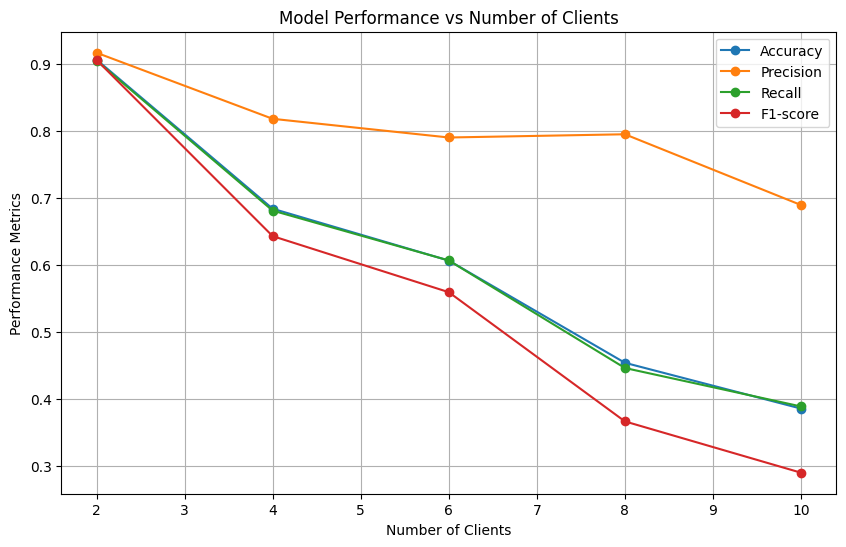

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
K.clear_session()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return model

def federated_learning(num_clients):
    client_models = []
    client_data = []

    for i in range(num_clients):
        x_train_client, _, y_train_client, _ = train_test_split(x_train, y_train, test_size=1-1/num_clients, random_state=42+i)
        client_data.append((x_train_client, y_train_client))

    for i in range(num_clients):
        client_model = create_client_model()
        client_model = train_client_model(client_model, client_data[i][0], client_data[i][1])
        client_models.append(client_model)

    def federated_average_weights(weights):
        new_weights = []
        for weights_list_tuple in zip(*weights):
            new_weights.append(np.array([np.array(weights_).mean(axis=0) for weights_ in zip(*weights_list_tuple)]))
        return new_weights

    aggregated_weights = federated_average_weights([model.get_weights() for model in client_models])

    global_model = create_client_model()
    global_model.set_weights(aggregated_weights)

    test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)

    y_pred = global_model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    precision = precision_score(y_test, y_pred_classes, average='macro')
    recall = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')

    return test_acc, precision, recall, f1

num_clients_list = [2, 4, 6, 8, 10]
accuracies = []
precisions = []
recalls = []
f1_scores = []

for num_clients in num_clients_list:
    acc, prec, rec, f1 = federated_learning(num_clients)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(num_clients_list, accuracies, marker='o', label='Accuracy')
plt.plot(num_clients_list, precisions, marker='o', label='Precision')
plt.plot(num_clients_list, recalls, marker='o', label='Recall')
plt.plot(num_clients_list, f1_scores, marker='o', label='F1-score')
plt.xlabel('Number of Clients')
plt.ylabel('Performance Metrics')
plt.title('Model Performance vs Number of Clients')
plt.legend()
plt.grid(True)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


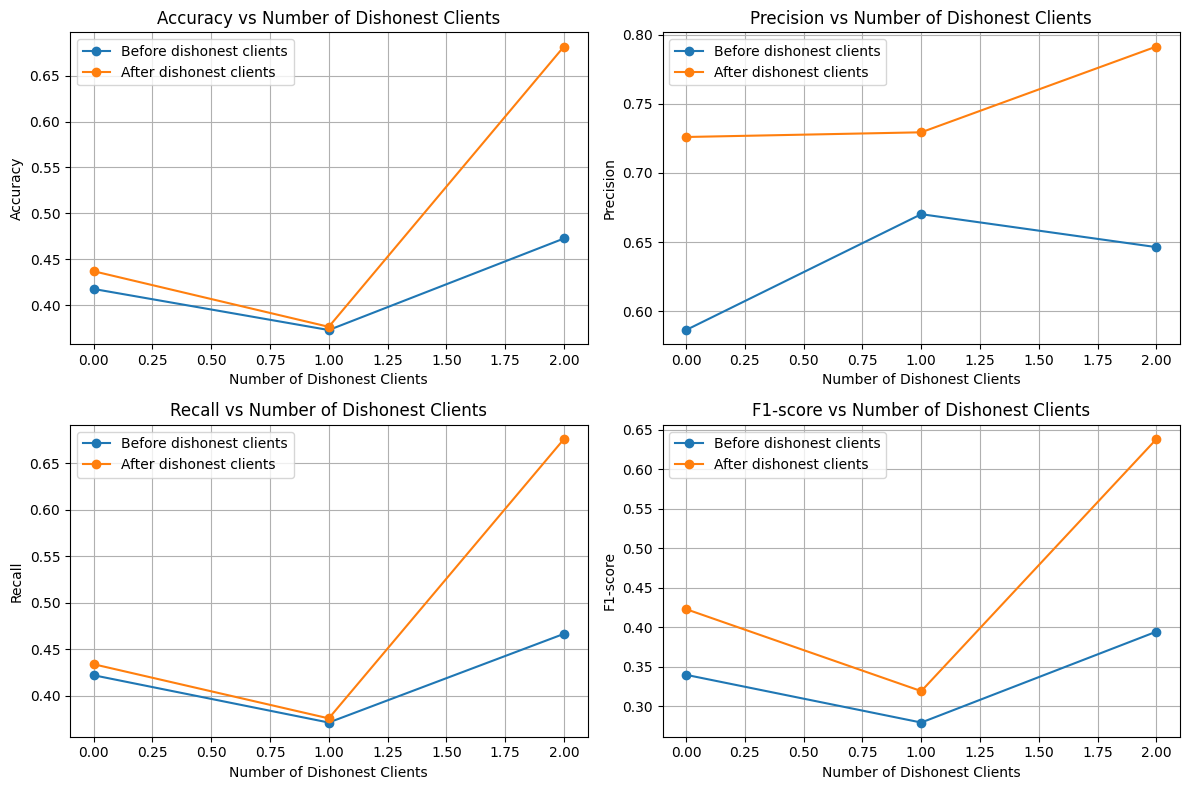

In [7]:
def create_dishonest_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_dishonest_client_model(model, x_train, y_train, epochs=5):
    # Simulate dishonest clients by training on random labels
    y_train_random = np.random.randint(0, 10, size=y_train.shape)
    model.fit(x_train, y_train_random, epochs=epochs, verbose=0)
    return model

def federated_learning(num_clients, num_dishonest_clients=0):
    client_models = []
    client_data = []

    for i in range(num_clients):
        x_train_client, _, y_train_client, _ = train_test_split(x_train, y_train, test_size=1-1/num_clients, random_state=42+i)
        client_data.append((x_train_client, y_train_client))

    for i in range(num_clients):
        if i < num_dishonest_clients:
            client_model = create_dishonest_client_model()
            client_model = train_dishonest_client_model(client_model, client_data[i][0], client_data[i][1])
        else:
            client_model = create_client_model()
            client_model = train_client_model(client_model, client_data[i][0], client_data[i][1])
        client_models.append(client_model)

    def federated_average_weights(weights):
        new_weights = []
        for weights_list_tuple in zip(*weights):
            new_weights.append(np.array([np.array(weights_).mean(axis=0) for weights_ in zip(*weights_list_tuple)]))
        return new_weights

    aggregated_weights = federated_average_weights([model.get_weights() for model in client_models])

    global_model = create_client_model()
    global_model.set_weights(aggregated_weights)

    test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=0)

    y_pred = global_model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    precision = precision_score(y_test, y_pred_classes, average='macro')
    recall = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')

    return test_acc, precision, recall, f1

def compare_performance(num_clients):
    num_dishonest_clients_list = [0, 1, 2]
    metrics_before = []
    metrics_after = []

    for num_dishonest_clients in num_dishonest_clients_list:
        acc_before, prec_before, rec_before, f1_before = federated_learning(num_clients)
        acc_after, prec_after, rec_after, f1_after = federated_learning(num_clients, num_dishonest_clients)

        metrics_before.append((acc_before, prec_before, rec_before, f1_before))
        metrics_after.append((acc_after, prec_after, rec_after, f1_after))

    return metrics_before, metrics_after

num_clients = 10
metrics_before, metrics_after = compare_performance(num_clients)

# Plot the performance metrics
plt.figure(figsize=(12, 8))
x = [0, 1, 2]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(x, [metric[i] for metric in metrics_before], marker='o', label='Before dishonest clients')
    plt.plot(x, [metric[i] for metric in metrics_after], marker='o', label='After dishonest clients')
    plt.xlabel('Number of Dishonest Clients')
    plt.ylabel(metrics[i])
    plt.title(f'{metrics[i]} vs Number of Dishonest Clients')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Lab Logbook requirement: Document the following in lablogbook

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.





# Challenges (Optional):

## The above code is for one communication round. Write code for multiple communication rounds. In each communication round, clients will train the model on a new dataset. Then the server will merge all these models. Subsequently, the clients will retrain the merged model in the next communication round.

